### 엔환 환율 예측

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('8.8.1.1 주요국통화의 대원화 환.csv', encoding='cp949', header=1, index_col=0)
df.head()

,원/미국달러(매매기준율),원/일본엔(100엔)
항목명1,,
단위,원,원
변환,원자료,원자료
2018/06/29,"1,121.70","1,014.79"
2018/06/30,NaN,NaN
2018/07/01,NaN,NaN


### 데이터 정제 작업

In [10]:
df2 = df.iloc[2:] # 불필요한 문자행을 없앤다.
df2 = df2.dropna().replace(',', '', regex=True)
df2 = df2.astype('float')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 2018/06/29 to 2019/07/02
Data columns (total 2 columns):
원/미국달러(매매기준율)    248 non-null float64
원/일본엔(100엔)      248 non-null float64
dtypes: float64(2)
memory usage: 5.8+ KB


In [11]:
df2.head()

,원/미국달러(매매기준율),원/일본엔(100엔)
항목명1,,
2018/06/29,1121.7,1014.79
2018/07/02,1117.2,1009.26
2018/07/03,1117.4,1008.26
2018/07/04,1121.1,1014.34
2018/07/05,1115.3,1009.55


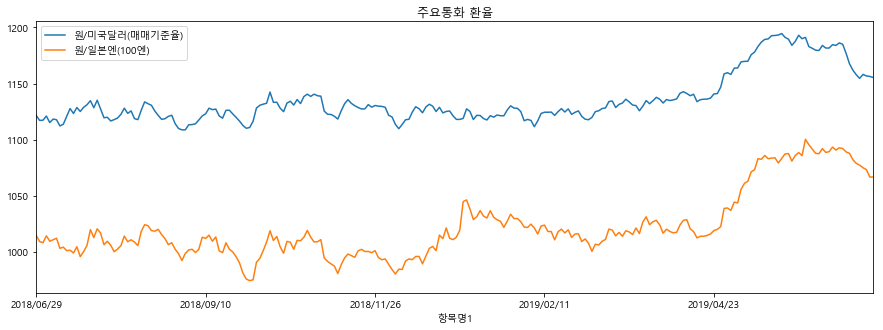

In [14]:
plt.rc('font', family='Malgun Gothic')
df2.plot(figsize=(15, 5), title='주요통화 환율')
plt.show()

In [112]:
# 예측을 위해 살펴볼 데이터의 범위를 window 라 한다.
window_week = 4
window_day = window_week * 5 # 주말 제외
predict_day = 5

X, Y 갯수
- 데이터가 30개 있으면? 20개로부터 5일 예측하므로 (20 + 5) 가 1 샘플(set), 총 6 샘플.
- 현재 데이터 248 개, 총 224 쌍의 X, Y 를 만든다.
- X[224, 2 * 20], y[224, 2 * 5]

In [113]:
print('총 데이터 개수={}, 샘플 크기={}, 총 샘플 수={}'
      .format(len(df2), (window_day + predict_day), (len(df2) - (window_day + predict_day) + 1)))

총 데이터 개수=248, 샘플 크기=25, 총 샘플 수=224


In [114]:
before = df2.iloc[:-predict_day] # 최근 데이터 중 최종 예측범위 제외
later = df2.iloc[window_day:] # 과거 데이터 중 최초 window 범위 제외
before.shape, later.shape

((243, 2), (228, 2))

In [115]:
m = len(df2) - (window_day + predict_day) + 1
m

224

In [116]:
x_list = []
y_list = []
for i in range(m): # 이해?를 돕기위해 df2 를 쓴다. 원래는 before, later 을 써야.
    x = df2.iloc[i:(i + window_day)] # 20일간의 X 데이터
    y = df2.iloc[(i + window_day):(i + window_day + predict_day)]
    x_list.append(x.values)
    y_list.append(y.values)

In [117]:
X = np.array(x_list)
y = np.array(y_list)
X.shape, y.shape # (m-instance, day, columns)

((224, 20, 2), (224, 5, 2))

In [118]:
# 2차원으로 변환. linear 이 2차원을 요구
X = np.reshape(X, [m, -1])
y = np.reshape(y, [m, -1])
X.shape, y.shape # (달러, 엔화, 달러, 엔화)

((224, 40), (224, 10))

In [119]:
X[:1]

array([[1121.7 , 1014.79, 1117.2 , 1009.26, 1117.4 , 1008.26, 1121.1 ,
        1014.34, 1115.3 , 1009.55, 1118.4 , 1010.85, 1117.8 , 1012.22,
        1112.3 , 1003.2 , 1113.8 , 1004.28, 1120.8 , 1001.16, 1127.8 ,
        1001.55, 1123.4 ,  999.07, 1128.7 , 1004.63, 1125.2 ,  995.84,
        1128.9 , 1000.31, 1131.2 , 1005.91, 1134.8 , 1019.91, 1128.5 ,
        1012.79, 1135.2 , 1020.63, 1127.5 , 1016.73]])

In [120]:
# train / test 분리
offset = 30
X_train = X[offset:]
X_test = X[:offset]
y_train = y[offset:]
y_test = y[:offset]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((194, 40), (30, 40), (194, 10), (30, 10))

In [121]:
from sklearn.linear_model import Ridge

In [122]:
lr = Ridge()
lr.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [123]:
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9205409191491469, -0.6542108232125314)

In [124]:
# 미래의 5일 환율 예측을 그래프로 시각화
최근20일 = df2.iloc[-window_day:].values.reshape([1, -1])
미래5일 = lr.predict(최근20일)
미래5일 = np.reshape(미래5일, [predict_day, 2])
미래5일.shape

(5, 2)

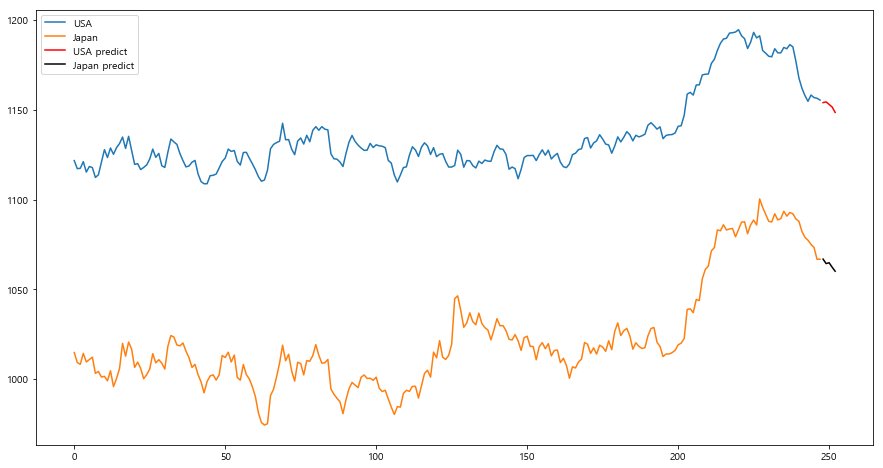

In [125]:
plt.figure(figsize=(15, 8))
usa = df2.iloc[:, 0].values
japan = df2.iloc[:, 1].values
x_num = np.arange(len(usa))
x1_num = np.arange(len(usa), len(usa) + len(미래5일))
plt.plot(x_num, usa, label='USA')
plt.plot(x_num, japan, label='Japan')
plt.plot(x1_num, 미래5일[:, 0], color='red', label='USA predict')
plt.plot(x1_num, 미래5일[:, 1], color='black', label='Japan predict')
plt.legend()
plt.show()